# 모방학습 기반 자율주행 (실습)

## Data 다운로드

In [1]:
from google.colab import files
import os
if not 'data' in os.listdir():
    files.upload() #upload kaggle.json
    !pip install -q kaggle
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json
    !kaggle datasets download -d hyunkunkookminuniv/behavioralcloning
    !unzip -q behavioralcloning.zip -d ./data

Saving kaggle.json to kaggle.json
kaggle.json
100% 1.08G/1.09G [00:07<00:00, 151MB/s]
100% 1.09G/1.09G [00:07<00:00, 165MB/s]


## 필수 라이브러리 임포트

In [2]:
import glob
import shutil
import os
import random
from PIL import Image

import pandas as pd
import numpy as np
from tqdm import notebook

import matplotlib.pyplot as plt

In [3]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras 

from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense, Input, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization,Add,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LeakyReLU, ReLU, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, UpSampling2D, concatenate
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# 실습 데이터

In [4]:
df1 = pd.read_csv('/content/data/data1/log.csv')
df2 = pd.read_csv('/content/data/data2/log.csv')
df3 = pd.read_csv('/content/data/data3/log.csv')

print(len(df1))

804


In [5]:
df1.head()

,t,x,y,z,pitch,yaw,roll,vx,vy,vz,throttle,steer,brake,reverse,gear
0,0.033333,-256.0,-11.999998,-0.018810,-0.000581,179.999954,-0.000671,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,False,0
1,0.333333,-256.0,-11.999998,-0.019682,-0.000581,179.999954,-0.000671,1.093149e-08,7.887701e-08,0.001220,0.621264,0.011783,0.621264,False,0
2,0.666667,-256.0,-11.999998,-0.019444,-0.000581,179.999954,-0.000671,2.025853e-08,3.042292e-08,0.000380,0.363130,0.011783,0.621264,False,0
3,0.966667,-256.0,-11.999998,-0.019400,-0.000581,179.999954,-0.000671,4.079034e-09,6.914056e-08,0.000013,0.358104,-0.004398,0.621264,False,0
4,1.300000,-256.0,-11.999998,-0.019398,-0.000581,179.999954,-0.000671,2.485921e-08,8.699285e-09,0.000001,0.382976,-0.012589,0.621264,False,0


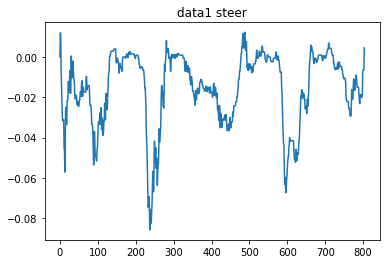

In [6]:
plt.title("data1 steer")
plt.plot(df1.steer)

In [7]:
log_df1 = pd.read_csv('/content/data/data1/log.csv')
log_df2 = pd.read_csv('/content/data/data2/log.csv')
log_df3 = pd.read_csv('/content/data/data3/log.csv')
log_df4 = pd.read_csv('/content/data/data4/log.csv')

logs = [log_df1, log_df2, log_df3, log_df4]

# steer 값을 0~1로 맞추기위한 수식

for i in range(len(logs)):
    logs[i] = 10*logs[i]['steer'].values
    
    logs[i][logs[i] > 1] = 1.0
    logs[i][logs[i] < -1] = -1.0
    logs[i] += 1
    logs[i] /= 2


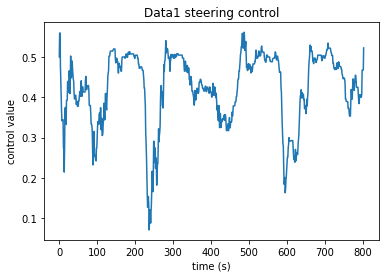

In [8]:
plt.plot(logs[0])
plt.xlabel("time (s)")
plt.ylabel("control value")
plt.title("Data1 steering control")
plt.show()

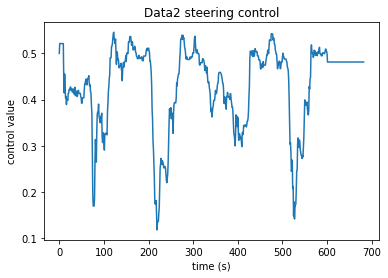

In [9]:
plt.plot(logs[1])
plt.xlabel("time (s)")
plt.ylabel("control value")
plt.title("Data2 steering control")
plt.show()

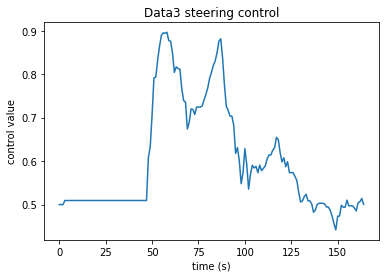

In [10]:
plt.plot(logs[2])
plt.xlabel("time (s)")
plt.ylabel("control value")
plt.title("Data3 steering control")
plt.show()

# 인공 신경망 생성

In [33]:
class Autonomous_Model(keras.Model):
    def __init__(self):
        super().__init__()
        # 24개 피쳐로 이루어진 컨볼루션 레이어
        # MaxPooling는 이미지 크기를 줄여주는 함수
        self.conv1 = Conv2D(24, 5, padding='valid')
      # self.add1 = BatchNormalization()
        self.mp1 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')
        
        # self.conv2 = Conv2D(36, 5, padding='valid')
        # # self.add2 = BatchNormalization()
        # self.mp2 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')
        
        self.conv3 = Conv2D(48, 5, padding='valid')
        # self.add3 = BatchNormalization()
        self.mp3 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')

        # self.conv4 = Conv2D(64, 3, padding='valid')
        # # self.add4 = BatchNormalization()
        # self.mp4 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')

        self.conv5 = Conv2D(64, 3, padding='valid')
        # self.add5 = BatchNormalization()
        self.mp5 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')

        self.flatten = tf.keras.layers.Flatten()

        self.d1 = Dense(1164)

        # self.d2 = Dense(100)

        self.d3 = Dense(50)

        # self.d4 = Dense(10)

        self.d5 = Dense(1)


# input_tensor를 변수 x로 통일
    def call(self, input_tensor, *args, **kwargs):
      
      # 컨볼루션 레이어를 5번 통과
        x = self.conv1(input_tensor)
        x = tf.nn.relu(x)
        x = self.mp1(x)

        # x = self.conv2(x)
        # x = tf.nn.relu(x)
        # x = self.mp2(x)

        x = self.conv3(x)
        x = tf.nn.relu(x)
        x = self.mp3(x)

        # x = self.conv4(x)
        # x = tf.nn.relu(x)
        # x = self.mp4(x)

        x = self.conv5(x)
        x = tf.nn.relu(x)
        x = self.mp5(x)

        # dense 레이어에 통과시키기 위해 x를 2d가 아닌 1d로 변환

        x = self.flatten(x)

        # dense 레이어를 5번 통과

        x = self.d1(x)

        # x = self.d2(x)

        x = self.d3(x)

        # x = self.d4(x)

        x = self.d5(x)

        return tf.keras.activations.sigmoid(x)

In [34]:
Steer_model = Autonomous_Model()

Steer_model.compile(optimizer='Adam', loss = 'BCE',  metrics=['mae'])
Steer_model.build(input_shape=(None, 256,512,3))
Steer_model.summary()

Model: "autonomous__model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          multiple                  1824      
                                                                 
 max_pooling2d_14 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          multiple                  28848     
                                                                 
 max_pooling2d_15 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          multiple                  27712     
                                                                 
 max_pooling2d_16 (MaxPoolin  multiple         

# 데이터 불러오기

In [38]:
# Data Loader 생성하기
# 학습에 필요한 데이터를 불러오고 데이터 전처리와 확장 적용,
# 케라스의 Sequence를 활용한 데이터 전처리 방법 지정

class steer_loader(Sequence):
  # shift 옵션은 센터카메라뿐만 아니라 왼쪽 오른쪽 카메라도 동시에 활용할 수 있게한다.
    def __init__(self, img_path, labels, batch_size = 16, shuffle = False, flip=False, bias=0, shift=False, rotate=False):
        self.batch_size = batch_size
        self.img_path = img_path
        self.img_list_c = sorted(os.listdir(self.img_path+"center/rgb/"))
        self.img_list_l = sorted(os.listdir(self.img_path+"left/rgb/"))
        self.img_list_r = sorted(os.listdir(self.img_path+"right/rgb/"))
        self.labels = labels
        self.dataset_size = len(self.img_list_c)
        self.shuffle = shuffle
        self.flip = flip
        self.on_epoch_end()
        self.bias = bias
        self.shift = shift
        self.rotate = rotate
        
    def __len__(self):

        return int(np.floor(self.dataset_size) / self.batch_size)
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.dataset_size)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):

        indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        cur_batch_name_list = [self.img_list_c[k] for k in indexes]
        label_list = np.array([self.labels[k] for k in indexes])
        
        data_list = []
        for i, data in enumerate(cur_batch_name_list):
            if self.shift:
                img_from = np.random.choice(["center/rgb/", "left/rgb/", "right/rgb/"])
            else:
                img_from = "center/rgb/"
            if img_from == "left/rgb/":
              # bias는 중앙카메라가 왼쪽 or 오른쪽 카메라를 처리할때 값을 주는 것
                label_list[i] += self.bias
                data = self.img_list_l[indexes[i]]
            if img_from == "right/rgb/":
                label_list[i] -= self.bias
                data = self.img_list_r[indexes[i]]

            img_data = np.array(image.img_to_array(Image.open(self.img_path + img_from + data)))/255
            img_data = img_data[:,:,:3]

            
            if self.flip and np.random.uniform() > 0.5:
                img_data = img_data[:,::-1,:]
                label_list[i] = 1 - label_list[i]


            data_list.append(img_data)
        data_list = np.array(data_list)
        data_list = tf.convert_to_tensor(data_list, dtype=tf.float32)
        return data_list , label_list

In [36]:
train_loader1 =  steer_loader('/content/data/data1/', logs[0],flip=True, shift=True, bias=0.05, rotate=False)
train_loader2 =  steer_loader('/content/data/data2/', logs[1],flip=True, shift=True, bias=0.05, rotate=False)
train_loader3 =  steer_loader('/content/data/data3/', logs[2],flip=False, bias=0.05, rotate=False)

val_loader = steer_loader('/content/data/data3/', logs[2],flip=True)

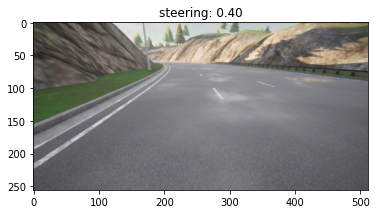

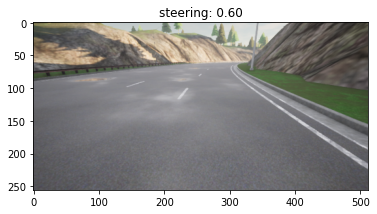

In [37]:
imgs, labels = train_loader1.__getitem__(2)

i = 10
plt.imshow(imgs[i])
plt.title(f"steering: {labels[i]:.2f}")
plt.show()

plt.imshow(imgs[i][:,::-1,:])
plt.title(f"steering: {1 - labels[i]:.2f}")
plt.show()

# 학습 및 평가

In [39]:
# Data Loader에 학습시키기

for i in range(3):
    Steer_model.fit(train_loader1, validation_data = val_loader, epochs=1)

    Steer_model.fit(train_loader2, validation_data = val_loader, epochs=1)

    Steer_model.fit(train_loader3, validation_data = val_loader, epochs=1)

10/10 [==============================] - 5s 477ms/step - loss: 0.6708 - mae: 0.0905 - val_loss: 0.6923 - val_mae: 0.1390


  0%|          | 0/10 [00:00<?, ?it/s]

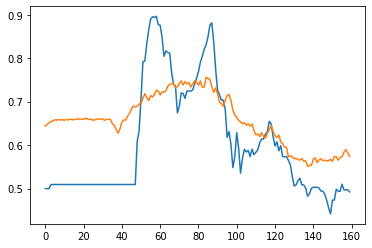

In [42]:
test_loader = steer_loader('/content/data/data3/', logs[2], shuffle = False, flip=False)
target = []
pred = []
a = 0
for data, label in notebook.tqdm(test_loader):
    y_pred = Steer_model(data)
    for i, j in zip(label, y_pred):
        target.append(i)
        pred.append(j)

    a += 1
# before 1 epoch
time_idx = np.arange(len(target))
plt.plot(time_idx, target, time_idx, pred)

  0%|          | 0/42 [00:00<?, ?it/s]

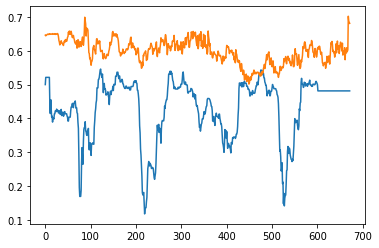

In [41]:
test_loader = steer_loader('/content/data/data2/', logs[1], shuffle = False, flip=False)
target = []
pred = []
a = 0
for data, label in notebook.tqdm(test_loader):
    y_pred = Steer_model(data)
    for i, j in zip(label, y_pred):
        target.append(i)
        pred.append(j)

    a += 1
# before 1 epoch
time_idx = np.arange(len(target))
plt.plot(time_idx, target, time_idx, pred)

  0%|          | 0/50 [00:00<?, ?it/s]

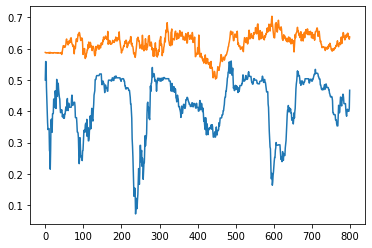

In [43]:
test_loader = steer_loader('/content/data/data1/', logs[0], shuffle = False, flip=False)
target = []
pred = []
a = 0
for data, label in notebook.tqdm(test_loader):
    y_pred = Steer_model(data)
    for i, j in zip(label, y_pred):
        target.append(i)
        pred.append(j)

    a += 1
# before 1 epoch
time_idx = np.arange(len(target))
plt.plot(time_idx, target, time_idx, pred)